## Extract Data for training
First collect and unpack our dataset. This command unzips the data for training and testing and moves it to the preservation directory.

In [1]:
import shutil
import zipfile
import os
shutil.rmtree('hw9')
os.mkdir('hw9')
f = zipfile.ZipFile('Linnaeus5128X128.zip')# 读取zip文件
f.extractall('hw9')#提取zip文件
shutil.move('hw9/Linnaeus5128X128/train', 'hw9')
shutil.move('hw9/Linnaeus5128X128/test', 'hw9')
shutil.rmtree('hw9/Linnaeus5128X128')
#!mv Linnaeus5128X128/train hw9
#!mv Linnaeus5128X128/test hw9
#!rmdir Linnaeus5128X128

In [2]:
from glob import glob
from sklearn.model_selection import train_test_split
## Randomly Split data into training and validation
# This code randomly chooses 30% of the training data for validation
# and then creates a val folder with that set of data.

In [3]:
dirs = glob('hw9/train/*')
print(dirs)
berry = glob('hw9/train/berry/*.jpg')
bird = glob('hw9/train/bird/*.jpg')
dog = glob('hw9/train/dog/*.jpg')
flower = glob('hw9/train/flower/*.jpg')
other = glob('hw9/train/other/*.jpg')

# Split into train and validation sets. 
berry_train, berry_val = train_test_split(berry, test_size=0.3)
bird_train, bird_val = train_test_split(bird, test_size=0.3)
dog_train, dog_val = train_test_split(dog, test_size=0.3)
flower_train, flower_val = train_test_split(flower, test_size=0.3)
other_train, other_val = train_test_split(other, test_size=0.3)

['hw9/train\\berry', 'hw9/train\\bird', 'hw9/train\\dog', 'hw9/train\\flower', 'hw9/train\\other']


In [4]:
# This code moves the validation files out of the train directory and over to 
# the val directory.
#shutil.rmtree('hw9/val')
os.mkdir('hw9/val')
#!rm -rf hw9/val
#!mkdir hw9/val

#!mkdir hw9/val/berry
#files = ' '.join(berry_val)
#!mv -t hw9/val/berry $files
os.mkdir('hw9/val/berry')
for i in range(len(berry_val)):
    shutil.move(berry_train[i], 'hw9/val/berry')

#!mkdir hw9/val/bird
#files = ' '.join(bird_val)
#!mv -t hw9/val/bird $files
os.mkdir('hw9/val/bird')
for i in range(len(bird_val)):
    shutil.move(bird_val[i], 'hw9/val/bird')
    
#!mkdir hw9/val/dog
#files = ' '.join(dog_val)
#!mv -t hw9/val/dog $files
os.mkdir('hw9/val/dog')
for i in range(len(dog_val)):
    shutil.move(dog_val[i], 'hw9/val/dog')
    
#!mkdir hw9/val/flower
#files = ' '.join(flower_val)
#!mv -t hw9/val/flower $files
os.mkdir('hw9/val/flower')
for i in range(len(flower_val)):
    shutil.move(flower_val[i], 'hw9/val/flower')
    
#!mkdir hw9/val/other
#files = ' '.join(other_val)
#!mv -t hw9/val/other $files
os.mkdir('hw9/val/other')
for i in range(len(other_val)):
    shutil.move(other_val[i], 'hw9/val/other')

In [5]:
# Jupyter keeps checkpoint files that may screw up the ImageDataGenerator class
# So we delete those here. 
#!rm -rf train/.ipynb_checkpoints
#!rm -rf val/.ipynb_checkpoints
#shutil.rmtree('train/.ipynb_checkpoints')
#shutil.rmtree('val/.ipynb_checkpoints')

## Augment Data for Training
Even the provided dataset is not small. We increase the effective size of the dataset by performing some preprocessing augmentations. By scaling, rotating, and flipping the images, we can create new images to increase the size of our dataset and ensure that our model is invariant to these transformations. Keras has a built in class called [ImageDataGenerator](https://keras.io/api/preprocessing/image/) that allows us to perform these operations and more. 

In this case, we split the data into training and validation, and allow for up to 90 degrees of rotation, and up to a doubling in zoom level as well as flipping across the y axis.

Keras provides the class ImageDataGenerator() for data augmentation. This class can be parametrized to implement several transformations, and our task will be decide which transformations make sense for our data. Images will be directly taken form our defined folder structure using the method flow_from_directory().

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

TRAIN_DIR = 'hw9/train'
VAL_DIR = 'hw9/val'
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 11

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 4200 images belonging to 5 classes.
Found 1800 images belonging to 5 classes.


## Load Pre-trained model

We can load the pre-trained googlenet InceptionV4 Model directly from the keras.applications package. By specifying ```include_top=False```, we remove the final classification layers from the model. We will be replacing the top layers with our own. 

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=False)

If you wish to see the structure of the InceptionV3 network, you can run the following cell. 

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Replace classification layer

Here we add the final classification layers back to the network.

In [9]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


CLASSES = 5
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
model = Model(inputs=base_model.input, outputs=predictions)

We only want to train the final layers of the network, so we set this flag to ensure that the pre-trained layers maintained.

In [10]:
for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

Finally we compile our Model

In [11]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train the network

In [18]:
EPOCHS = 30
BATCH_SIZE = 20
STEPS_PER_EPOCH = 3
VALIDATION_STEPS = 1
#MODEL_FILE = 'hw9.model'
MODEL_FILE = 'savedmodel/hw9model'

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)

Epoch 1/30
3/3 [==============================] - 2s 559ms/step - loss: 0.5531 - accuracy: 0.7879 - val_loss: 0.2657 - val_accuracy: 0.9091
Epoch 2/30
3/3 [==============================] - 1s 460ms/step - loss: 0.6882 - accuracy: 0.7576 - val_loss: 0.7205 - val_accuracy: 0.7273
Epoch 3/30
3/3 [==============================] - 1s 472ms/step - loss: 0.6502 - accuracy: 0.7879 - val_loss: 0.4767 - val_accuracy: 0.8182
Epoch 4/30
3/3 [==============================] - 1s 479ms/step - loss: 0.4505 - accuracy: 0.8485 - val_loss: 0.2793 - val_accuracy: 1.0000
Epoch 5/30
3/3 [==============================] - 1s 489ms/step - loss: 0.6024 - accuracy: 0.8485 - val_loss: 0.7797 - val_accuracy: 0.8182
Epoch 6/30
3/3 [==============================] - 2s 571ms/step - loss: 0.5653 - accuracy: 0.7576 - val_loss: 0.8658 - val_accuracy: 0.8182
Epoch 7/30
3/3 [==============================] - 1s 476ms/step - loss: 0.6400 - accuracy: 0.8182 - val_loss: 0.1950 - val_accuracy: 1.0000
Epoch 8/30
3/3 [====

In [19]:
model.save(MODEL_FILE)

INFO:tensorflow:Assets written to: savedmodel/hw9model\assets


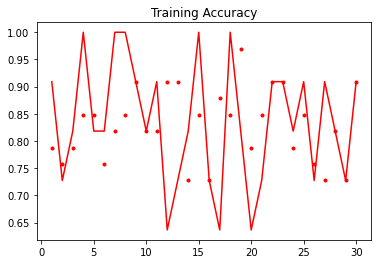

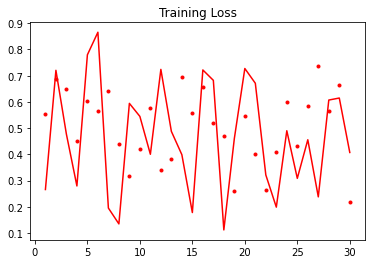

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

## Test Trained Network

Finally, we can see how our trained network does classifying a new image. 

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import seaborn as sn

In [22]:
berry_test = glob('hw9/test/berry/*.jpg')
bird_test = glob('hw9/test/bird/*.jpg')
dog_test = glob('hw9/test/dog/*.jpg')
flower_test = glob('hw9/test/flower/*.jpg')
other_test = glob('hw9/test/other/*.jpg')

In [23]:
# data prep
TEST_DIR = 'hw9/test'
WIDTH = 299
HEIGHT = 299

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,fill_mode='nearest')
test_generator = validation_datagen.flow_from_directory(TEST_DIR,target_size=(HEIGHT, WIDTH),class_mode='categorical')


Found 2000 images belonging to 5 classes.


In [24]:
model = load_model(MODEL_FILE)

In [25]:
pred_label = list()
for i in range(len(test_generator.filenames)):
    img = image.load_img(test_generator.directory+'/'+test_generator.filenames[i], target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred_label.append(np.argmax(model.predict(x)[0]))

In [26]:
pred_labels = np.array(pred_label).astype(np.int32)

Confusion matrix:
[[341.   0.   0.  10.  12.]
 [ 15. 396.   8.   9.  85.]
 [  2.   2. 378.   2.  38.]
 [ 35.   0.   0. 379.  17.]
 [  7.   2.  14.   0. 248.]]


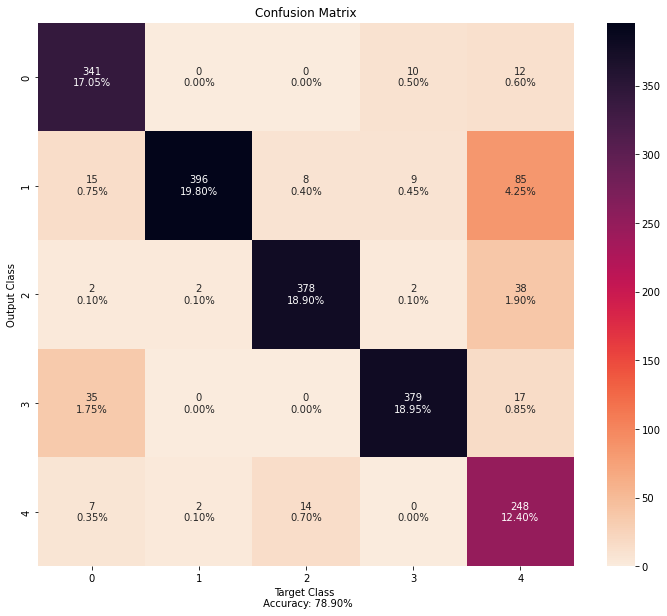

In [27]:
#plot confusion matrix
c_mat = np.zeros((5,5))
for i in range(test_generator.labels.shape[0]):
    c_mat[pred_labels[i], test_generator.labels[i]] += 1

print("Confusion matrix:\n" + str(c_mat))

group_counts = ["{0:0.0f}".format(value) for value in c_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(c_mat.shape[0], c_mat.shape[1])

accuracy = (np.sum(np.logical_and(pred_labels, test_generator.labels))/ len(test_generator.labels)) * 100

plt.figure(figsize=(12,10))
sn.heatmap(c_mat, annot=labels, fmt='', cmap='rocket_r')
plt.title("Confusion Matrix")
plt.ylabel('Output Class')
_ = plt.xlabel('Target Class \n Accuracy: ' + '%.2f'%accuracy + "%")